# Notebook for Convolutional Neural Network with Torchvision- Pytorch

### Imports & Installations

In [63]:
#pip install torchvision

In [64]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

### Class distribution

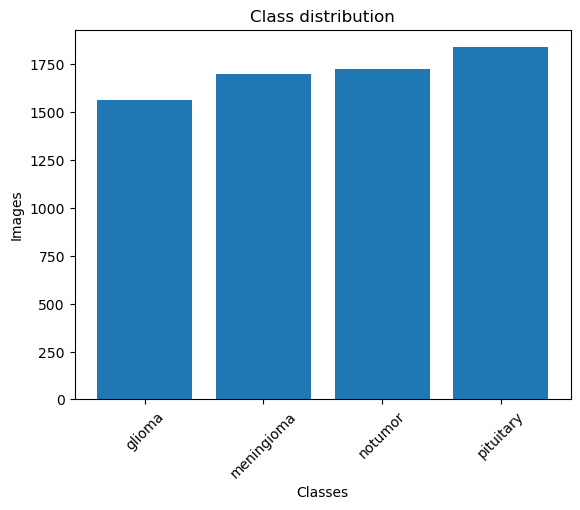

In [65]:
# Distribution of images per class in the training dataset 
labels_list = [label for _, label in train_dataset]
class_counts = Counter(labels_list)

plt.bar(train_dataset.classes, class_counts.values())
plt.title("Class distribution")
plt.xlabel("Classes")
plt.ylabel("Images")
plt.xticks(rotation=45)
plt.show()

### Image examples

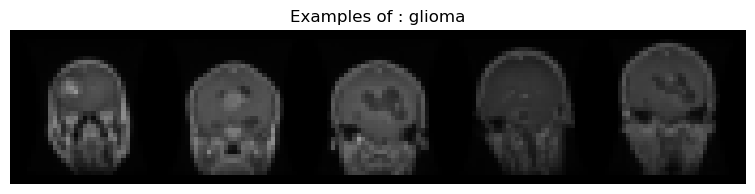

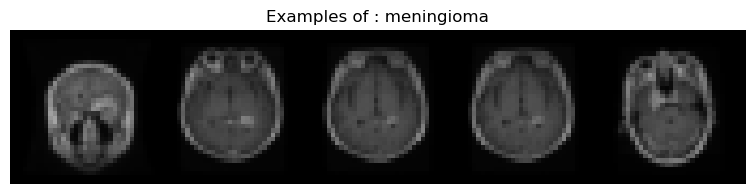

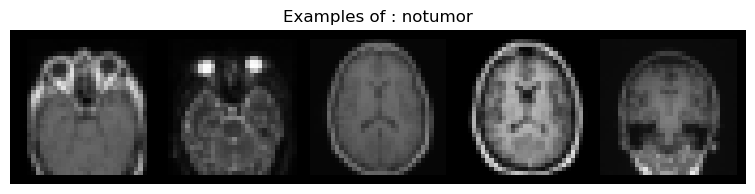

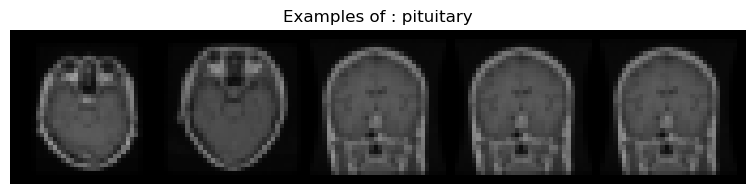

In [66]:
# EDA analysis dataset 
eda_transform = transforms.Compose([
    transforms.Grayscale(),       
    transforms.Resize((32, 32)),  
    transforms.ToTensor()
])

eda_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=eda_transform)

# Showing images function
def show_images_by_class(dataset, class_idx, n=5):
    imgs = [img for img, label in dataset if label == class_idx][:n]
    grid = torchvision.utils.make_grid(imgs, nrow=n, padding=2)
    npimg = grid.numpy()
    
    # Mostrar en escala de grises correctamente
    plt.figure(figsize=(10, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.title(f"Examples of : {dataset.classes[class_idx]}")
    plt.axis('off')
    plt.show()

# Showing n images
for i in range(len(eda_dataset.classes)):
    show_images_by_class(eda_dataset, i)

### Augmented examples 

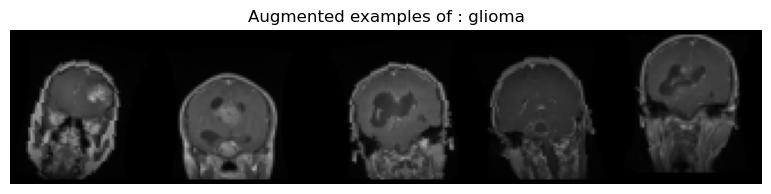

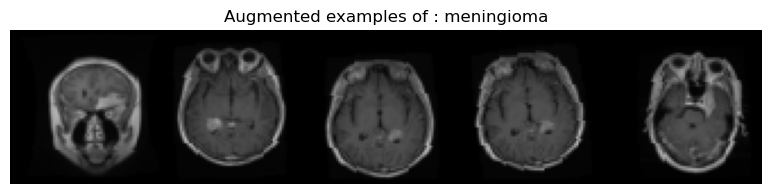

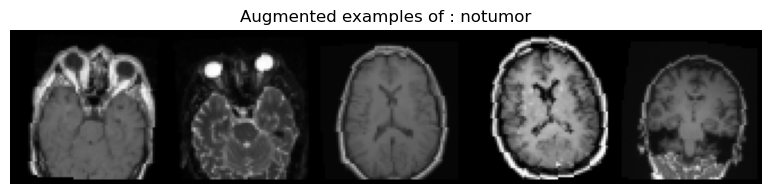

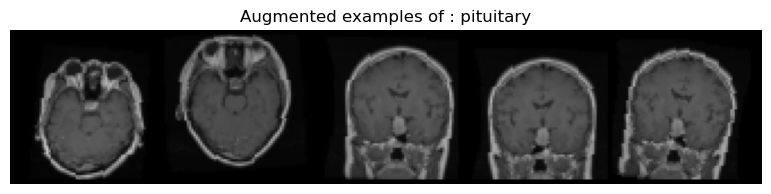

In [67]:
# Dataset with data augmentation
eda_augmented_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

eda_augmented_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=eda_augmented_transform)

# Plotting the classes with their respecting images 
def show_augmented_images_by_class(dataset, class_idx, n=5):
    imgs = [img for img, label in dataset if label == class_idx][:n]
    grid = torchvision.utils.make_grid(imgs, nrow=n, padding=2)
    npimg = grid.numpy()

    plt.figure(figsize=(10, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.title(f"Augmented examples of : {dataset.classes[class_idx]}")
    plt.axis('off')
    plt.show()

# Images per class
for i in range(len(eda_augmented_dataset.classes)):
    show_augmented_images_by_class(eda_augmented_dataset, i)


### Previous Transformations

In [86]:
# Transformations
training_transform = transforms.Compose([
    transforms.Grayscale(),                  # grayscale
    transforms.Resize((64, 64)),             # resizing the data 
    transforms.ToTensor(),                   # converting to a tensor 
    transforms.Normalize((0.5,), (0.5,)),    # normalizing 
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),

])

eval_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data route 
data_dir = "../Data"  

# Loading datasets 
training_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=training_transform)
trainval_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=eval_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "Testing"), transform=eval_transform)

train_size = int(0.8 * len(trainval_dataset))
val_size = len(training_dataset) - train_size

# Seed and random generated subsets
generator = torch.Generator().manual_seed(42)
train_subset, _ = random_split(training_dataset, [train_size, val_size], generator=generator)
_, val_subset = random_split(trainval_dataset, [train_size, val_size], generator=generator)


# Data loaders 
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Classes
print("Class list:", training_dataset.classes)

Class list: ['glioma', 'meningioma', 'notumor', 'pituitary']


### Architecture of the network 

In [87]:
class Net(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Convoluciones
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  

        self.pool = nn.MaxPool2d(2, 2)  

        
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 64, 64)  
            out = self.pool(F.relu(self.conv1(dummy)))
            out = self.pool(F.relu(self.conv2(out)))
            out = self.pool(F.relu(self.conv3(out)))
            flat_size = out.view(1, -1).shape[1]

        # Capas totalmente conectadas
        self.fc1 = nn.Linear(flat_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # → (B, 16, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))  # → (B, 32, 16, 16)
        x = self.pool(F.relu(self.conv3(x)))  
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))               # → (B, 128)
        x = F.relu(self.fc2(x))               # → (B, 64)
        x = self.fc3(x)                       # → (B, 4)
        return x


In [93]:
len(val_loader)

43

In [92]:
len(test_loader)

45

In [102]:
# NNetwork and CUDA
net = Net(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [103]:
# Definition of the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [104]:
# Training
for epoch in range(10):  # epochs
    net.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] Train Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # Validation
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total

    print(f"Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f} | Accuracy = {accuracy:.4f}")

print("Training finished")


[1,   100] Train Loss: 1.041
Epoch 1: Val Loss = 0.7582 | Accuracy = 0.7048
[2,   100] Train Loss: 0.753
Epoch 2: Val Loss = 0.7083 | Accuracy = 0.7179
[3,   100] Train Loss: 0.646
Epoch 3: Val Loss = 0.5301 | Accuracy = 0.7949
[4,   100] Train Loss: 0.536
Epoch 4: Val Loss = 0.5937 | Accuracy = 0.7524
[5,   100] Train Loss: 0.518
Epoch 5: Val Loss = 0.4087 | Accuracy = 0.8396
[6,   100] Train Loss: 0.467
Epoch 6: Val Loss = 0.5304 | Accuracy = 0.7817
[7,   100] Train Loss: 0.410
Epoch 7: Val Loss = 0.3455 | Accuracy = 0.8652
[8,   100] Train Loss: 0.395
Epoch 8: Val Loss = 0.3397 | Accuracy = 0.8681
[9,   100] Train Loss: 0.383
Epoch 9: Val Loss = 0.2947 | Accuracy = 0.8850
[10,   100] Train Loss: 0.336
Epoch 10: Val Loss = 0.2606 | Accuracy = 0.8923
Training finished


In [106]:
# Test Evaluation
net.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"\nFinal test evaluation:")
print(f"📉 Test Loss: {avg_test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")



Final test evaluation:
📉 Test Loss: 0.3676
✅ Test Accuracy: 0.8526
